# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_55166/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_55166/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_55166/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:

hyperparameters= {
                "transformation": {
                    "sigma_a": 10,
                    "sigma_b": 5,
                    "RW1": {
                        "tau_a": 10,
                        "tau_b": 15
                    },
                    "RW2": {
                        "tau_a": 6,
                        "tau_b": 10
                        }
                    },
                "decorrelation": {
                    "sigma_a": 10,
                    "sigma_b": 5,
                    "RW1": {
                        "tau_a": 10,
                        "tau_b": 5
                        },
                    "RW2": {
                        "tau_a": 10,
                        "tau_b": 15
                        }
                    }
                }

hyperparameters = {
  "transformation": {
    "sigma_a": 2, "sigma_b": 10,         # mean σ² = 10  (weak ridge)
    "RW2": { "tau_a": 2, "tau_b": 1.0 }, # mean τ² = 1.0 (moderate smoothing)
    "RW1": {"tau_a": 10, "tau_b": 15 }   # RW1 ignored for transformation; omit it.
  },
  "decorrelation": {
    "sigma_a": 2, "sigma_b": 10,        # mean σ² = 10  (weak ridge; lets K drive smoothing)
    "RW1": { "tau_a": 2, "tau_b": 0.3 },# mean τ₁² = 0.3 (strong pull-to-linear)
    "RW2": { "tau_a": 2, "tau_b": 1.0 } # mean τ₂² = 1.0 (moderate curvature smoothing)
  }
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=1,
    degree_transformations=3,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    inference = 'bayesian',
    device="cpu",
    hyperparameter=hyperparameters
    )
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

52


In [9]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [10]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=1.5,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=101.6087  val=98.3485  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0507  σmin=0.0507  σmax=0.0507


  0%|          | 2/1000 [00:01<08:23,  1.98it/s]

[2/1000] train=94.3006  val=97.5903  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0515  σmin=0.0515  σmax=0.0515


  0%|          | 3/1000 [00:01<08:01,  2.07it/s]

[3/1000] train=97.4127  val=96.8311  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0522  σmin=0.0522  σmax=0.0522


  0%|          | 4/1000 [00:01<06:53,  2.41it/s]

[4/1000] train=95.2429  val=96.0727  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 5/1000 [00:02<06:53,  2.40it/s]

[5/1000] train=93.6144  val=95.3132  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0538  σmin=0.0538  σmax=0.0538


  1%|          | 6/1000 [00:02<06:47,  2.44it/s]

[6/1000] train=94.5555  val=94.5544  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0546  σmin=0.0546  σmax=0.0546


  1%|          | 7/1000 [00:03<07:27,  2.22it/s]

[7/1000] train=94.9658  val=93.7961  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0554  σmin=0.0554  σmax=0.0554


  1%|          | 8/1000 [00:03<07:16,  2.27it/s]

[8/1000] train=92.7317  val=93.0376  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 9/1000 [00:04<07:20,  2.25it/s]

[9/1000] train=95.8709  val=92.2806  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0570  σmin=0.0570  σmax=0.0570


  1%|          | 10/1000 [00:04<06:42,  2.46it/s]

[10/1000] train=92.2333  val=91.5238  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0579  σmin=0.0579  σmax=0.0579


  1%|          | 11/1000 [00:04<06:07,  2.69it/s]

[11/1000] train=94.7560  val=90.7672  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0587  σmin=0.0587  σmax=0.0587


  1%|          | 12/1000 [00:04<05:43,  2.87it/s]

[12/1000] train=93.8828  val=90.0103  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|▏         | 13/1000 [00:05<05:26,  3.02it/s]

[13/1000] train=93.0254  val=89.2530  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0604  σmin=0.0604  σmax=0.0605


  1%|▏         | 14/1000 [00:05<05:20,  3.08it/s]

[14/1000] train=94.0588  val=88.4957  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0613  σmin=0.0613  σmax=0.0613


  2%|▏         | 15/1000 [00:05<04:54,  3.34it/s]

[15/1000] train=88.6998  val=87.7386  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0622  σmin=0.0622  σmax=0.0622


  2%|▏         | 16/1000 [00:06<04:54,  3.34it/s]

[16/1000] train=84.2346  val=86.9829  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0631  σmin=0.0631  σmax=0.0632


  2%|▏         | 17/1000 [00:06<04:48,  3.41it/s]

[17/1000] train=86.3199  val=86.2276  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0641  σmin=0.0641  σmax=0.0641


  2%|▏         | 18/1000 [00:06<04:29,  3.64it/s]

[18/1000] train=88.7851  val=85.4737  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0650  σmin=0.0650  σmax=0.0650


  2%|▏         | 19/1000 [00:06<04:42,  3.47it/s]

[19/1000] train=83.0966  val=84.7204  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0660  σmin=0.0660  σmax=0.0660


  2%|▏         | 20/1000 [00:07<04:35,  3.56it/s]

[20/1000] train=83.7629  val=83.9675  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 21/1000 [00:07<04:21,  3.74it/s]

[21/1000] train=83.6776  val=83.2151  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0679  σmin=0.0679  σmax=0.0679


  2%|▏         | 22/1000 [00:07<04:14,  3.85it/s]

[22/1000] train=83.5135  val=82.4631  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0689  σmin=0.0689  σmax=0.0689


  2%|▏         | 23/1000 [00:07<04:08,  3.93it/s]

[23/1000] train=82.7620  val=81.7110  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0699  σmin=0.0699  σmax=0.0699


  2%|▏         | 24/1000 [00:09<12:17,  1.32it/s]

[24/1000] train=80.9047  val=80.9601  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▎         | 25/1000 [00:10<09:41,  1.68it/s]

[25/1000] train=78.9283  val=80.2093  S_train=4 S_val=16 lr=[0.01, 0.015]σ̄=0.0719  σmin=0.0719  σmax=0.0720


  3%|▎         | 26/1000 [00:10<07:59,  2.03it/s]

[26/1000] train=79.5990  val=79.4595  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0730  σmin=0.0730  σmax=0.0730


  3%|▎         | 27/1000 [00:10<06:56,  2.34it/s]

[27/1000] train=79.0057  val=78.7105  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0741  σmin=0.0740  σmax=0.0741


  3%|▎         | 28/1000 [00:10<05:58,  2.71it/s]

[28/1000] train=79.0869  val=77.9624  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0751  σmin=0.0751  σmax=0.0752


  3%|▎         | 29/1000 [00:11<05:19,  3.04it/s]

[29/1000] train=75.3055  val=77.2147  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0762  σmin=0.0762  σmax=0.0762


  3%|▎         | 30/1000 [00:11<04:58,  3.25it/s]

[30/1000] train=81.0290  val=76.4670  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0773  σmin=0.0773  σmax=0.0774


  3%|▎         | 31/1000 [00:11<04:45,  3.40it/s]

[31/1000] train=78.6509  val=75.7195  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0785  σmin=0.0784  σmax=0.0785


  3%|▎         | 32/1000 [00:11<04:25,  3.65it/s]

[32/1000] train=77.0275  val=74.9725  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  3%|▎         | 33/1000 [00:12<04:12,  3.83it/s]

[33/1000] train=74.6840  val=74.2256  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0808  σmin=0.0807  σmax=0.0808


  3%|▎         | 34/1000 [00:12<03:57,  4.07it/s]

[34/1000] train=73.5359  val=73.4797  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0819  σmin=0.0819  σmax=0.0819


  4%|▎         | 35/1000 [00:12<03:46,  4.26it/s]

[35/1000] train=73.7415  val=72.7342  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0831  σmin=0.0831  σmax=0.0831


  4%|▎         | 36/1000 [00:12<03:36,  4.45it/s]

[36/1000] train=72.7765  val=71.9897  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  4%|▎         | 37/1000 [00:12<03:31,  4.55it/s]

[37/1000] train=70.8985  val=71.2453  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0855  σmin=0.0855  σmax=0.0856


  4%|▍         | 38/1000 [00:13<03:27,  4.63it/s]

[38/1000] train=67.0939  val=70.5021  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0868  σmin=0.0868  σmax=0.0868


  4%|▍         | 39/1000 [00:13<03:37,  4.41it/s]

[39/1000] train=70.0925  val=69.7598  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0880  σmin=0.0880  σmax=0.0881


  4%|▍         | 40/1000 [00:13<03:35,  4.45it/s]

[40/1000] train=66.8789  val=69.0179  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  4%|▍         | 41/1000 [00:13<03:30,  4.55it/s]

[41/1000] train=68.7726  val=68.2777  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0906  σmin=0.0906  σmax=0.0906


  4%|▍         | 42/1000 [00:13<03:26,  4.64it/s]

[42/1000] train=69.7999  val=67.5373  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0919  σmin=0.0919  σmax=0.0919


  4%|▍         | 43/1000 [00:14<03:23,  4.70it/s]

[43/1000] train=64.0965  val=66.7969  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0932  σmin=0.0932  σmax=0.0933


  4%|▍         | 44/1000 [00:14<03:32,  4.51it/s]

[44/1000] train=64.8483  val=66.0557  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0946  σmin=0.0945  σmax=0.0946


  4%|▍         | 45/1000 [00:14<03:28,  4.59it/s]

[45/1000] train=65.5996  val=65.3149  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0959  σmin=0.0959  σmax=0.0960


  5%|▍         | 46/1000 [00:14<03:23,  4.68it/s]

[46/1000] train=66.1842  val=64.5748  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0973  σmin=0.0973  σmax=0.0974


  5%|▍         | 47/1000 [00:15<03:20,  4.75it/s]

[47/1000] train=62.9979  val=63.8354  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.0987  σmin=0.0987  σmax=0.0988


  5%|▍         | 48/1000 [00:15<03:18,  4.79it/s]

[48/1000] train=63.9730  val=63.0975  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  5%|▍         | 49/1000 [00:15<03:17,  4.81it/s]

[49/1000] train=64.1794  val=62.3607  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1016  σmin=0.1015  σmax=0.1016


  5%|▌         | 50/1000 [00:15<03:21,  4.72it/s]

[50/1000] train=59.8603  val=61.6248  S_train=8 S_val=16 lr=[0.01, 0.015]σ̄=0.1030  σmin=0.1030  σmax=0.1031


  5%|▌         | 51/1000 [00:15<03:48,  4.15it/s]

[51/1000] train=62.3377  val=60.8900  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1045  σmin=0.1045  σmax=0.1046


  5%|▌         | 52/1000 [00:16<04:06,  3.84it/s]

[52/1000] train=59.8703  val=60.1561  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1060  σmin=0.1060  σmax=0.1061


  5%|▌         | 53/1000 [00:16<04:18,  3.67it/s]

[53/1000] train=58.8001  val=59.4230  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1075  σmin=0.1075  σmax=0.1076


  5%|▌         | 54/1000 [00:16<04:25,  3.56it/s]

[54/1000] train=57.2631  val=58.6901  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1091  σmin=0.1090  σmax=0.1092


  6%|▌         | 55/1000 [00:17<04:29,  3.50it/s]

[55/1000] train=59.8086  val=57.9572  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1106  σmin=0.1106  σmax=0.1107


  6%|▌         | 56/1000 [00:17<04:39,  3.38it/s]

[56/1000] train=55.8302  val=57.2252  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1122  σmin=0.1121  σmax=0.1123


  6%|▌         | 57/1000 [00:17<04:41,  3.36it/s]

[57/1000] train=54.4916  val=56.4936  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1138  σmin=0.1137  σmax=0.1139


  6%|▌         | 58/1000 [00:18<04:41,  3.34it/s]

[58/1000] train=56.8189  val=55.7623  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1154  σmin=0.1154  σmax=0.1156


  6%|▌         | 59/1000 [00:18<04:43,  3.32it/s]

[59/1000] train=55.3453  val=55.0323  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1171  σmin=0.1170  σmax=0.1172


  6%|▌         | 60/1000 [00:18<04:46,  3.28it/s]

[60/1000] train=53.1881  val=54.3026  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1188  σmin=0.1187  σmax=0.1189


  6%|▌         | 61/1000 [00:18<04:46,  3.27it/s]

[61/1000] train=55.8207  val=53.5742  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1204  σmin=0.1204  σmax=0.1206


  6%|▌         | 62/1000 [00:19<04:48,  3.25it/s]

[62/1000] train=52.9843  val=52.8475  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1222  σmin=0.1221  σmax=0.1223


  6%|▋         | 63/1000 [00:19<04:49,  3.23it/s]

[63/1000] train=51.4093  val=52.1217  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1239  σmin=0.1238  σmax=0.1241


  6%|▋         | 64/1000 [00:19<04:49,  3.24it/s]

[64/1000] train=51.4417  val=51.3969  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1257  σmin=0.1256  σmax=0.1258


  6%|▋         | 65/1000 [00:20<04:49,  3.23it/s]

[65/1000] train=51.6164  val=50.6732  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1274  σmin=0.1273  σmax=0.1276


  7%|▋         | 66/1000 [00:20<04:49,  3.22it/s]

[66/1000] train=51.3431  val=49.9501  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1292  σmin=0.1291  σmax=0.1294


  7%|▋         | 67/1000 [00:20<04:51,  3.20it/s]

[67/1000] train=50.3300  val=49.2282  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1311  σmin=0.1310  σmax=0.1313


  7%|▋         | 68/1000 [00:21<04:50,  3.21it/s]

[68/1000] train=50.9215  val=48.5077  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1329  σmin=0.1328  σmax=0.1331


  7%|▋         | 69/1000 [00:21<05:13,  2.97it/s]

[69/1000] train=46.4697  val=47.7877  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1348  σmin=0.1347  σmax=0.1350


  7%|▋         | 70/1000 [00:21<05:21,  2.89it/s]

[70/1000] train=48.1707  val=47.0685  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1367  σmin=0.1366  σmax=0.1370


  7%|▋         | 71/1000 [00:22<05:28,  2.83it/s]

[71/1000] train=46.8603  val=46.3500  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1386  σmin=0.1385  σmax=0.1389


  7%|▋         | 72/1000 [00:22<05:32,  2.79it/s]

[72/1000] train=46.5990  val=45.6320  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1406  σmin=0.1405  σmax=0.1409


  7%|▋         | 73/1000 [00:22<05:18,  2.91it/s]

[73/1000] train=42.7273  val=44.9149  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1426  σmin=0.1425  σmax=0.1429


  7%|▋         | 74/1000 [00:23<05:07,  3.01it/s]

[74/1000] train=44.9258  val=44.1993  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1446  σmin=0.1445  σmax=0.1449


  8%|▊         | 75/1000 [00:23<04:59,  3.09it/s]

[75/1000] train=43.6167  val=43.4841  S_train=16 S_val=16 lr=[0.01, 0.015]σ̄=0.1466  σmin=0.1465  σmax=0.1469


  8%|▊         | 76/1000 [00:24<05:50,  2.64it/s]

[76/1000] train=43.1173  val=42.7702  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1487  σmin=0.1485  σmax=0.1490


  8%|▊         | 77/1000 [00:24<06:27,  2.38it/s]

[77/1000] train=43.1217  val=42.0583  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1508  σmin=0.1506  σmax=0.1511


  8%|▊         | 78/1000 [00:25<06:52,  2.24it/s]

[78/1000] train=42.8942  val=41.3481  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1529  σmin=0.1527  σmax=0.1533


  8%|▊         | 79/1000 [00:25<07:08,  2.15it/s]

[79/1000] train=41.1671  val=40.6399  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1550  σmin=0.1548  σmax=0.1554


  8%|▊         | 80/1000 [00:26<08:34,  1.79it/s]

[80/1000] train=40.9966  val=39.9332  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1572  σmin=0.1570  σmax=0.1576


  8%|▊         | 81/1000 [00:27<09:52,  1.55it/s]

[81/1000] train=38.8982  val=39.2273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1594  σmin=0.1592  σmax=0.1598


  8%|▊         | 82/1000 [00:28<10:41,  1.43it/s]

[82/1000] train=38.7728  val=38.5233  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1616  σmin=0.1614  σmax=0.1621


  8%|▊         | 83/1000 [00:29<12:21,  1.24it/s]

[83/1000] train=38.4675  val=37.8209  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1638  σmin=0.1636  σmax=0.1644


  8%|▊         | 84/1000 [00:29<11:28,  1.33it/s]

[84/1000] train=36.9755  val=37.1205  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1661  σmin=0.1659  σmax=0.1667


  8%|▊         | 85/1000 [00:30<10:34,  1.44it/s]

[85/1000] train=36.9523  val=36.4211  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1684  σmin=0.1682  σmax=0.1690


  9%|▊         | 86/1000 [00:30<09:54,  1.54it/s]

[86/1000] train=36.2845  val=35.7226  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1708  σmin=0.1705  σmax=0.1714


  9%|▊         | 87/1000 [00:31<09:27,  1.61it/s]

[87/1000] train=34.4822  val=35.0244  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1731  σmin=0.1729  σmax=0.1738


  9%|▉         | 88/1000 [00:32<09:17,  1.63it/s]

[88/1000] train=34.7132  val=34.3266  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1755  σmin=0.1753  σmax=0.1762


  9%|▉         | 89/1000 [00:32<09:47,  1.55it/s]

[89/1000] train=34.6453  val=33.6292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1780  σmin=0.1777  σmax=0.1787


  9%|▉         | 90/1000 [00:33<09:33,  1.59it/s]

[90/1000] train=33.3865  val=32.9333  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1804  σmin=0.1801  σmax=0.1812


  9%|▉         | 91/1000 [00:33<09:26,  1.60it/s]

[91/1000] train=31.7392  val=32.2389  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1829  σmin=0.1826  σmax=0.1837


  9%|▉         | 92/1000 [00:35<14:27,  1.05it/s]

[92/1000] train=33.2339  val=31.5456  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1855  σmin=0.1851  σmax=0.1863


  9%|▉         | 93/1000 [00:36<12:40,  1.19it/s]

[93/1000] train=31.2700  val=30.8528  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1880  σmin=0.1876  σmax=0.1889


  9%|▉         | 94/1000 [00:36<11:24,  1.32it/s]

[94/1000] train=31.1937  val=30.1614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1906  σmin=0.1902  σmax=0.1915


 10%|▉         | 95/1000 [00:37<10:55,  1.38it/s]

[95/1000] train=30.6115  val=29.4697  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1932  σmin=0.1928  σmax=0.1942


 10%|▉         | 96/1000 [00:38<10:50,  1.39it/s]

[96/1000] train=28.8931  val=28.7778  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1959  σmin=0.1954  σmax=0.1969


 10%|▉         | 97/1000 [00:38<10:15,  1.47it/s]

[97/1000] train=29.5862  val=28.0870  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.1985  σmin=0.1981  σmax=0.1996


 10%|▉         | 98/1000 [00:39<09:28,  1.59it/s]

[98/1000] train=27.0118  val=27.3980  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2013  σmin=0.2008  σmax=0.2024


 10%|▉         | 99/1000 [00:39<09:11,  1.63it/s]

[99/1000] train=28.0082  val=26.7116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2040  σmin=0.2035  σmax=0.2052


 10%|█         | 100/1000 [00:40<09:04,  1.65it/s]

[100/1000] train=26.9186  val=26.0270  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2068  σmin=0.2063  σmax=0.2081


 10%|█         | 101/1000 [00:41<09:09,  1.64it/s]

[101/1000] train=25.7016  val=25.3450  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2096  σmin=0.2091  σmax=0.2109


 10%|█         | 102/1000 [00:41<09:08,  1.64it/s]

[102/1000] train=25.2105  val=24.6662  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2125  σmin=0.2119  σmax=0.2139


 10%|█         | 103/1000 [00:42<08:48,  1.70it/s]

[103/1000] train=24.0113  val=23.9894  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2154  σmin=0.2148  σmax=0.2168


 10%|█         | 104/1000 [00:42<08:24,  1.77it/s]

[104/1000] train=23.2002  val=23.3146  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2183  σmin=0.2176  σmax=0.2198


 10%|█         | 105/1000 [00:43<09:00,  1.66it/s]

[105/1000] train=23.2721  val=22.6422  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2212  σmin=0.2206  σmax=0.2229


 11%|█         | 106/1000 [00:44<10:15,  1.45it/s]

[106/1000] train=21.8681  val=21.9717  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2242  σmin=0.2235  σmax=0.2259


 11%|█         | 107/1000 [00:45<10:27,  1.42it/s]

[107/1000] train=21.4890  val=21.3031  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2273  σmin=0.2265  σmax=0.2291


 11%|█         | 108/1000 [00:45<10:04,  1.48it/s]

[108/1000] train=21.1111  val=20.6375  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2303  σmin=0.2296  σmax=0.2322


 11%|█         | 109/1000 [00:46<09:40,  1.53it/s]

[109/1000] train=20.5991  val=19.9734  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2334  σmin=0.2327  σmax=0.2354


 11%|█         | 110/1000 [00:46<09:28,  1.57it/s]

[110/1000] train=20.3305  val=19.3117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2366  σmin=0.2358  σmax=0.2387


 11%|█         | 111/1000 [00:47<09:15,  1.60it/s]

[111/1000] train=17.7419  val=18.6539  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2397  σmin=0.2389  σmax=0.2419


 11%|█         | 112/1000 [00:48<08:58,  1.65it/s]

[112/1000] train=19.2293  val=17.9972  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2430  σmin=0.2421  σmax=0.2453


 11%|█▏        | 113/1000 [00:48<08:43,  1.70it/s]

[113/1000] train=17.4560  val=17.3412  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2462  σmin=0.2453  σmax=0.2486


 11%|█▏        | 114/1000 [00:49<08:31,  1.73it/s]

[114/1000] train=17.6464  val=16.6856  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2495  σmin=0.2485  σmax=0.2521


 12%|█▏        | 115/1000 [00:49<08:23,  1.76it/s]

[115/1000] train=16.1031  val=16.0304  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2528  σmin=0.2518  σmax=0.2555


 12%|█▏        | 116/1000 [00:50<08:23,  1.76it/s]

[116/1000] train=15.6757  val=15.3780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2562  σmin=0.2551  σmax=0.2590


 12%|█▏        | 117/1000 [00:50<08:15,  1.78it/s]

[117/1000] train=14.7029  val=14.7279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2596  σmin=0.2585  σmax=0.2626


 12%|█▏        | 118/1000 [00:51<08:10,  1.80it/s]

[118/1000] train=15.2187  val=14.0815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2630  σmin=0.2619  σmax=0.2661


 12%|█▏        | 119/1000 [00:51<08:08,  1.80it/s]

[119/1000] train=14.5044  val=13.4376  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2665  σmin=0.2653  σmax=0.2698


 12%|█▏        | 120/1000 [00:53<12:52,  1.14it/s]

[120/1000] train=13.1642  val=12.7975  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2700  σmin=0.2688  σmax=0.2735


 12%|█▏        | 121/1000 [00:54<11:31,  1.27it/s]

[121/1000] train=13.2041  val=12.1609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2736  σmin=0.2723  σmax=0.2772


 12%|█▏        | 122/1000 [00:54<10:30,  1.39it/s]

[122/1000] train=11.9731  val=11.5273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2772  σmin=0.2759  σmax=0.2810


 12%|█▏        | 123/1000 [00:55<09:42,  1.50it/s]

[123/1000] train=11.9070  val=10.8968  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2809  σmin=0.2795  σmax=0.2848


 12%|█▏        | 124/1000 [00:55<09:18,  1.57it/s]

[124/1000] train=9.8991  val=10.2666  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2845  σmin=0.2831  σmax=0.2887


 12%|█▎        | 125/1000 [00:56<08:56,  1.63it/s]

[125/1000] train=9.6973  val=9.6371  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2883  σmin=0.2868  σmax=0.2926


 13%|█▎        | 126/1000 [00:56<08:39,  1.68it/s]

[126/1000] train=9.2039  val=9.0123  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2920  σmin=0.2906  σmax=0.2966


 13%|█▎        | 127/1000 [00:57<08:26,  1.72it/s]

[127/1000] train=7.1863  val=8.3909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2959  σmin=0.2943  σmax=0.3006


 13%|█▎        | 128/1000 [00:57<08:18,  1.75it/s]

[128/1000] train=6.7511  val=7.7656  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.2997  σmin=0.2981  σmax=0.3047


 13%|█▎        | 129/1000 [00:58<08:11,  1.77it/s]

[129/1000] train=7.9199  val=7.1393  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3036  σmin=0.3020  σmax=0.3088


 13%|█▎        | 130/1000 [00:59<08:06,  1.79it/s]

[130/1000] train=6.0253  val=6.5103  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3075  σmin=0.3059  σmax=0.3130


 13%|█▎        | 131/1000 [00:59<08:07,  1.78it/s]

[131/1000] train=4.9247  val=5.8835  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3115  σmin=0.3098  σmax=0.3172


 13%|█▎        | 132/1000 [01:00<08:00,  1.81it/s]

[132/1000] train=5.6086  val=5.2617  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3156  σmin=0.3138  σmax=0.3215


 13%|█▎        | 133/1000 [01:01<09:33,  1.51it/s]

[133/1000] train=4.6832  val=4.6447  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3196  σmin=0.3178  σmax=0.3259


 13%|█▎        | 134/1000 [01:02<11:47,  1.22it/s]

[134/1000] train=4.7782  val=4.0314  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3237  σmin=0.3218  σmax=0.3303


 14%|█▎        | 135/1000 [01:03<12:07,  1.19it/s]

[135/1000] train=4.3810  val=3.4218  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3279  σmin=0.3258  σmax=0.3347


 14%|█▎        | 136/1000 [01:03<11:52,  1.21it/s]

[136/1000] train=3.3901  val=2.8160  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3321  σmin=0.3299  σmax=0.3393


 14%|█▎        | 137/1000 [01:04<10:43,  1.34it/s]

[137/1000] train=3.1314  val=2.2126  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3363  σmin=0.3341  σmax=0.3438


 14%|█▍        | 138/1000 [01:05<09:48,  1.47it/s]

[138/1000] train=1.8792  val=1.6175  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3406  σmin=0.3382  σmax=0.3484


 14%|█▍        | 139/1000 [01:05<09:07,  1.57it/s]

[139/1000] train=1.1741  val=1.0259  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3450  σmin=0.3424  σmax=0.3531


 14%|█▍        | 140/1000 [01:06<08:47,  1.63it/s]

[140/1000] train=-0.5791  val=0.4354  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3493  σmin=0.3467  σmax=0.3579


 14%|█▍        | 141/1000 [01:06<08:26,  1.69it/s]

[141/1000] train=0.2106  val=-0.1501  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3538  σmin=0.3510  σmax=0.3627


 14%|█▍        | 142/1000 [01:07<08:11,  1.75it/s]

[142/1000] train=-0.0251  val=-0.7348  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3583  σmin=0.3553  σmax=0.3675


 14%|█▍        | 143/1000 [01:07<08:01,  1.78it/s]

[143/1000] train=-1.7524  val=-1.3168  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3628  σmin=0.3597  σmax=0.3725


 14%|█▍        | 144/1000 [01:08<07:54,  1.80it/s]

[144/1000] train=-2.7453  val=-1.8963  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3673  σmin=0.3641  σmax=0.3775


 14%|█▍        | 145/1000 [01:08<07:52,  1.81it/s]

[145/1000] train=-2.8054  val=-2.4780  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3720  σmin=0.3686  σmax=0.3825


 15%|█▍        | 146/1000 [01:09<07:53,  1.80it/s]

[146/1000] train=-2.9289  val=-3.0509  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3766  σmin=0.3732  σmax=0.3877


 15%|█▍        | 147/1000 [01:09<08:12,  1.73it/s]

[147/1000] train=-3.3186  val=-3.6237  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3813  σmin=0.3778  σmax=0.3928


 15%|█▍        | 148/1000 [01:10<08:39,  1.64it/s]

[148/1000] train=-2.9856  val=-4.1948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3861  σmin=0.3824  σmax=0.3981


 15%|█▍        | 149/1000 [01:11<08:47,  1.61it/s]

[149/1000] train=-4.8254  val=-4.7561  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3909  σmin=0.3870  σmax=0.4034


 15%|█▌        | 150/1000 [01:11<08:27,  1.68it/s]

[150/1000] train=-5.0638  val=-5.3098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.3957  σmin=0.3916  σmax=0.4088


 15%|█▌        | 151/1000 [01:12<08:15,  1.71it/s]

[151/1000] train=-4.6809  val=-5.8623  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4006  σmin=0.3963  σmax=0.4143


 15%|█▌        | 152/1000 [01:12<08:10,  1.73it/s]

[152/1000] train=-6.2725  val=-6.4088  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4056  σmin=0.4012  σmax=0.4198


 15%|█▌        | 153/1000 [01:13<07:59,  1.77it/s]

[153/1000] train=-6.8956  val=-6.9528  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4105  σmin=0.4060  σmax=0.4254


 15%|█▌        | 154/1000 [01:14<08:18,  1.70it/s]

[154/1000] train=-8.1380  val=-7.4952  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4156  σmin=0.4108  σmax=0.4311


 16%|█▌        | 155/1000 [01:14<08:08,  1.73it/s]

[155/1000] train=-7.5625  val=-8.0325  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4207  σmin=0.4157  σmax=0.4369


 16%|█▌        | 156/1000 [01:15<08:04,  1.74it/s]

[156/1000] train=-7.4346  val=-8.5685  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4258  σmin=0.4206  σmax=0.4427


 16%|█▌        | 157/1000 [01:15<08:06,  1.73it/s]

[157/1000] train=-9.3186  val=-9.1002  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4310  σmin=0.4255  σmax=0.4486


 16%|█▌        | 158/1000 [01:16<08:08,  1.72it/s]

[158/1000] train=-9.6082  val=-9.6332  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4362  σmin=0.4305  σmax=0.4545


 16%|█▌        | 159/1000 [01:17<08:25,  1.66it/s]

[159/1000] train=-8.7118  val=-10.1619  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4414  σmin=0.4355  σmax=0.4606


 16%|█▌        | 160/1000 [01:17<08:26,  1.66it/s]

[160/1000] train=-10.0725  val=-10.6839  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4467  σmin=0.4405  σmax=0.4667


 16%|█▌        | 161/1000 [01:18<08:17,  1.69it/s]

[161/1000] train=-9.5321  val=-11.2070  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4520  σmin=0.4455  σmax=0.4728


 16%|█▌        | 162/1000 [01:18<08:08,  1.72it/s]

[162/1000] train=-10.6795  val=-11.7279  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4574  σmin=0.4507  σmax=0.4790


 16%|█▋        | 163/1000 [01:19<08:07,  1.72it/s]

[163/1000] train=-10.6044  val=-12.2378  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4628  σmin=0.4558  σmax=0.4853


 16%|█▋        | 164/1000 [01:20<11:58,  1.16it/s]

[164/1000] train=-12.8197  val=-12.7440  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4682  σmin=0.4611  σmax=0.4916


 16%|█▋        | 165/1000 [01:21<10:43,  1.30it/s]

[165/1000] train=-11.4438  val=-13.2496  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4737  σmin=0.4664  σmax=0.4980


 17%|█▋        | 166/1000 [01:22<09:51,  1.41it/s]

[166/1000] train=-12.7631  val=-13.7459  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4792  σmin=0.4715  σmax=0.5045


 17%|█▋        | 167/1000 [01:22<09:13,  1.51it/s]

[167/1000] train=-14.5397  val=-14.2363  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4847  σmin=0.4767  σmax=0.5110


 17%|█▋        | 168/1000 [01:23<08:58,  1.55it/s]

[168/1000] train=-13.3917  val=-14.7176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4902  σmin=0.4819  σmax=0.5175


 17%|█▋        | 169/1000 [01:23<09:05,  1.52it/s]

[169/1000] train=-14.7589  val=-15.1934  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.4957  σmin=0.4871  σmax=0.5241


 17%|█▋        | 170/1000 [01:24<09:32,  1.45it/s]

[170/1000] train=-16.0564  val=-15.6593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5013  σmin=0.4923  σmax=0.5308


 17%|█▋        | 171/1000 [01:25<09:04,  1.52it/s]

[171/1000] train=-15.0308  val=-16.1197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5068  σmin=0.4977  σmax=0.5375


 17%|█▋        | 172/1000 [01:25<08:55,  1.55it/s]

[172/1000] train=-15.3346  val=-16.5732  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5124  σmin=0.5031  σmax=0.5442


 17%|█▋        | 173/1000 [01:26<08:53,  1.55it/s]

[173/1000] train=-15.9915  val=-17.0222  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5180  σmin=0.5084  σmax=0.5510


 17%|█▋        | 174/1000 [01:27<08:39,  1.59it/s]

[174/1000] train=-17.6233  val=-17.4617  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5236  σmin=0.5137  σmax=0.5579


 18%|█▊        | 175/1000 [01:27<08:24,  1.64it/s]

[175/1000] train=-17.4809  val=-17.8913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5292  σmin=0.5190  σmax=0.5648


 18%|█▊        | 176/1000 [01:28<08:11,  1.68it/s]

[176/1000] train=-17.4185  val=-18.3100  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5349  σmin=0.5244  σmax=0.5717


 18%|█▊        | 177/1000 [01:28<08:01,  1.71it/s]

[177/1000] train=-18.3823  val=-18.7249  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5405  σmin=0.5296  σmax=0.5787


 18%|█▊        | 178/1000 [01:29<08:24,  1.63it/s]

[178/1000] train=-19.0268  val=-19.1394  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5461  σmin=0.5349  σmax=0.5857


 18%|█▊        | 179/1000 [01:30<08:09,  1.68it/s]

[179/1000] train=-18.3926  val=-19.5401  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5517  σmin=0.5402  σmax=0.5928


 18%|█▊        | 180/1000 [01:30<08:00,  1.70it/s]

[180/1000] train=-19.5824  val=-19.9327  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5574  σmin=0.5454  σmax=0.5999


 18%|█▊        | 181/1000 [01:31<07:51,  1.74it/s]

[181/1000] train=-19.8339  val=-20.3263  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5630  σmin=0.5506  σmax=0.6071


 18%|█▊        | 182/1000 [01:31<07:48,  1.74it/s]

[182/1000] train=-19.3934  val=-20.7117  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5687  σmin=0.5558  σmax=0.6143


 18%|█▊        | 183/1000 [01:32<07:52,  1.73it/s]

[183/1000] train=-21.1428  val=-21.0923  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5743  σmin=0.5609  σmax=0.6215


 18%|█▊        | 184/1000 [01:32<07:49,  1.74it/s]

[184/1000] train=-20.4813  val=-21.4670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5799  σmin=0.5661  σmax=0.6288


 18%|█▊        | 185/1000 [01:33<07:51,  1.73it/s]

[185/1000] train=-20.9019  val=-21.8328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5855  σmin=0.5713  σmax=0.6361


 19%|█▊        | 186/1000 [01:34<07:51,  1.73it/s]

[186/1000] train=-21.9626  val=-22.1909  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5912  σmin=0.5766  σmax=0.6435


 19%|█▊        | 187/1000 [01:34<07:47,  1.74it/s]

[187/1000] train=-21.0645  val=-22.5426  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.5968  σmin=0.5819  σmax=0.6508


 19%|█▉        | 188/1000 [01:35<07:58,  1.70it/s]

[188/1000] train=-21.8004  val=-22.8848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6024  σmin=0.5871  σmax=0.6583


 19%|█▉        | 189/1000 [01:35<08:02,  1.68it/s]

[189/1000] train=-22.3168  val=-23.2221  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6080  σmin=0.5924  σmax=0.6657


 19%|█▉        | 190/1000 [01:36<07:56,  1.70it/s]

[190/1000] train=-22.3224  val=-23.5496  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6136  σmin=0.5971  σmax=0.6732


 19%|█▉        | 191/1000 [01:36<07:52,  1.71it/s]

[191/1000] train=-23.2446  val=-23.8695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6192  σmin=0.6018  σmax=0.6808


 19%|█▉        | 192/1000 [01:37<07:57,  1.69it/s]

[192/1000] train=-24.8240  val=-24.1849  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6248  σmin=0.6065  σmax=0.6884


 19%|█▉        | 193/1000 [01:38<07:53,  1.71it/s]

[193/1000] train=-23.6711  val=-24.4951  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6303  σmin=0.6112  σmax=0.6960


 19%|█▉        | 194/1000 [01:38<07:50,  1.71it/s]

[194/1000] train=-24.2499  val=-24.7964  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6359  σmin=0.6158  σmax=0.7036


 20%|█▉        | 195/1000 [01:39<07:47,  1.72it/s]

[195/1000] train=-23.4527  val=-25.0887  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6414  σmin=0.6206  σmax=0.7113


 20%|█▉        | 196/1000 [01:40<12:09,  1.10it/s]

[196/1000] train=-23.3898  val=-25.3799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6470  σmin=0.6254  σmax=0.7190


 20%|█▉        | 197/1000 [01:41<10:55,  1.23it/s]

[197/1000] train=-24.2887  val=-25.6583  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6525  σmin=0.6302  σmax=0.7268


 20%|█▉        | 198/1000 [01:42<09:56,  1.34it/s]

[198/1000] train=-24.9576  val=-25.9237  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6580  σmin=0.6349  σmax=0.7346


 20%|█▉        | 199/1000 [01:42<09:13,  1.45it/s]

[199/1000] train=-25.6736  val=-26.1945  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6635  σmin=0.6395  σmax=0.7424


 20%|██        | 200/1000 [01:43<08:45,  1.52it/s]

[200/1000] train=-24.8255  val=-26.4604  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6689  σmin=0.6439  σmax=0.7502


 20%|██        | 201/1000 [01:43<08:25,  1.58it/s]

[201/1000] train=-25.2052  val=-26.7273  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6743  σmin=0.6484  σmax=0.7581


 20%|██        | 202/1000 [01:44<08:15,  1.61it/s]

[202/1000] train=-26.2753  val=-26.9880  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6797  σmin=0.6529  σmax=0.7660


 20%|██        | 203/1000 [01:45<08:06,  1.64it/s]

[203/1000] train=-27.2674  val=-27.2447  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6851  σmin=0.6574  σmax=0.7739


 20%|██        | 204/1000 [01:45<07:59,  1.66it/s]

[204/1000] train=-26.8835  val=-27.4990  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6904  σmin=0.6620  σmax=0.7819


 20%|██        | 205/1000 [01:46<07:53,  1.68it/s]

[205/1000] train=-26.0785  val=-27.7539  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.6957  σmin=0.6665  σmax=0.7899


 21%|██        | 206/1000 [01:46<08:00,  1.65it/s]

[206/1000] train=-26.1755  val=-28.0116  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7009  σmin=0.6710  σmax=0.7979


 21%|██        | 207/1000 [01:47<08:01,  1.65it/s]

[207/1000] train=-28.2347  val=-28.2670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7061  σmin=0.6757  σmax=0.8060


 21%|██        | 208/1000 [01:48<07:52,  1.67it/s]

[208/1000] train=-28.0026  val=-28.5189  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7113  σmin=0.6802  σmax=0.8140


 21%|██        | 209/1000 [01:48<07:46,  1.70it/s]

[209/1000] train=-27.9626  val=-28.7660  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7165  σmin=0.6848  σmax=0.8221


 21%|██        | 210/1000 [01:49<07:46,  1.69it/s]

[210/1000] train=-28.4639  val=-29.0090  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7215  σmin=0.6894  σmax=0.8303


 21%|██        | 211/1000 [01:49<07:44,  1.70it/s]

[211/1000] train=-27.7933  val=-29.2485  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7266  σmin=0.6941  σmax=0.8384


 21%|██        | 212/1000 [01:50<07:38,  1.72it/s]

[212/1000] train=-28.3870  val=-29.4843  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7316  σmin=0.6987  σmax=0.8466


 21%|██▏       | 213/1000 [01:50<07:33,  1.73it/s]

[213/1000] train=-28.3470  val=-29.7174  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7366  σmin=0.7032  σmax=0.8548


 21%|██▏       | 214/1000 [01:51<07:30,  1.74it/s]

[214/1000] train=-29.7529  val=-29.9390  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7415  σmin=0.7076  σmax=0.8631


 22%|██▏       | 215/1000 [01:52<07:33,  1.73it/s]

[215/1000] train=-28.4552  val=-30.1491  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7464  σmin=0.7109  σmax=0.8713


 22%|██▏       | 216/1000 [01:52<07:28,  1.75it/s]

[216/1000] train=-28.6568  val=-30.3478  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7513  σmin=0.7143  σmax=0.8796


 22%|██▏       | 217/1000 [01:53<07:28,  1.75it/s]

[217/1000] train=-29.6296  val=-30.5456  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7562  σmin=0.7177  σmax=0.8879


 22%|██▏       | 218/1000 [01:53<07:24,  1.76it/s]

[218/1000] train=-29.8105  val=-30.7388  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7610  σmin=0.7211  σmax=0.8963


 22%|██▏       | 219/1000 [01:54<07:22,  1.77it/s]

[219/1000] train=-30.0225  val=-30.9232  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7659  σmin=0.7245  σmax=0.9046


 22%|██▏       | 220/1000 [01:54<07:25,  1.75it/s]

[220/1000] train=-30.4057  val=-31.1035  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7706  σmin=0.7281  σmax=0.9130


 22%|██▏       | 221/1000 [01:55<07:47,  1.67it/s]

[221/1000] train=-29.2333  val=-31.2799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7754  σmin=0.7317  σmax=0.9214


 22%|██▏       | 222/1000 [01:56<07:36,  1.70it/s]

[222/1000] train=-29.4404  val=-31.4565  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7801  σmin=0.7356  σmax=0.9298


 22%|██▏       | 223/1000 [01:56<07:30,  1.73it/s]

[223/1000] train=-30.2416  val=-31.6285  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7848  σmin=0.7392  σmax=0.9382


 22%|██▏       | 224/1000 [01:57<07:34,  1.71it/s]

[224/1000] train=-30.6707  val=-31.7913  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7894  σmin=0.7428  σmax=0.9467


 22%|██▎       | 225/1000 [01:57<07:31,  1.72it/s]

[225/1000] train=-30.2914  val=-31.9473  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7940  σmin=0.7465  σmax=0.9552


 23%|██▎       | 226/1000 [01:58<07:27,  1.73it/s]

[226/1000] train=-30.4740  val=-32.1005  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.7986  σmin=0.7501  σmax=0.9637


 23%|██▎       | 227/1000 [01:59<07:28,  1.72it/s]

[227/1000] train=-31.1254  val=-32.2427  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8031  σmin=0.7539  σmax=0.9722


 23%|██▎       | 228/1000 [01:59<07:32,  1.71it/s]

[228/1000] train=-31.0592  val=-32.3769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8075  σmin=0.7575  σmax=0.9807


 23%|██▎       | 229/1000 [02:00<07:37,  1.69it/s]

[229/1000] train=-28.7919  val=-32.5098  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8119  σmin=0.7608  σmax=0.9893


 23%|██▎       | 230/1000 [02:00<07:33,  1.70it/s]

[230/1000] train=-30.9732  val=-32.6319  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8163  σmin=0.7642  σmax=0.9979


 23%|██▎       | 231/1000 [02:01<07:28,  1.71it/s]

[231/1000] train=-30.4287  val=-32.7575  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8206  σmin=0.7673  σmax=1.0065


 23%|██▎       | 232/1000 [02:01<07:32,  1.70it/s]

[232/1000] train=-31.4959  val=-32.8851  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8249  σmin=0.7703  σmax=1.0151


 23%|██▎       | 233/1000 [02:02<07:31,  1.70it/s]

[233/1000] train=-32.0400  val=-33.0036  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8291  σmin=0.7734  σmax=1.0237


 23%|██▎       | 234/1000 [02:03<07:30,  1.70it/s]

[234/1000] train=-31.9423  val=-33.1178  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8333  σmin=0.7763  σmax=1.0323


 24%|██▎       | 235/1000 [02:03<07:33,  1.69it/s]

[235/1000] train=-30.5940  val=-33.2322  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8374  σmin=0.7791  σmax=1.0410


 24%|██▎       | 236/1000 [02:04<07:33,  1.68it/s]

[236/1000] train=-32.0840  val=-33.3504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8415  σmin=0.7818  σmax=1.0497


 24%|██▎       | 237/1000 [02:05<11:11,  1.14it/s]

[237/1000] train=-32.2858  val=-33.4624  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8456  σmin=0.7843  σmax=1.0583


 24%|██▍       | 238/1000 [02:06<09:59,  1.27it/s]

[238/1000] train=-33.3659  val=-33.5712  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8496  σmin=0.7867  σmax=1.0670


 24%|██▍       | 239/1000 [02:07<09:09,  1.38it/s]

[239/1000] train=-30.9904  val=-33.6799  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8535  σmin=0.7891  σmax=1.0758


 24%|██▍       | 240/1000 [02:07<08:42,  1.45it/s]

[240/1000] train=-32.2077  val=-33.7863  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8574  σmin=0.7915  σmax=1.0845


 24%|██▍       | 241/1000 [02:08<08:15,  1.53it/s]

[241/1000] train=-31.4510  val=-33.8918  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8612  σmin=0.7941  σmax=1.0932


 24%|██▍       | 242/1000 [02:08<08:08,  1.55it/s]

[242/1000] train=-32.5964  val=-33.9941  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8650  σmin=0.7967  σmax=1.1020


 24%|██▍       | 243/1000 [02:09<07:53,  1.60it/s]

[243/1000] train=-32.5402  val=-34.1011  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8688  σmin=0.7995  σmax=1.1108


 24%|██▍       | 244/1000 [02:10<07:47,  1.62it/s]

[244/1000] train=-33.0406  val=-34.2147  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8726  σmin=0.8022  σmax=1.1195


 24%|██▍       | 245/1000 [02:10<07:37,  1.65it/s]

[245/1000] train=-32.8228  val=-34.3292  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8763  σmin=0.8050  σmax=1.1283


 25%|██▍       | 246/1000 [02:11<07:29,  1.68it/s]

[246/1000] train=-34.7865  val=-34.4414  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8799  σmin=0.8076  σmax=1.1371


 25%|██▍       | 247/1000 [02:11<07:23,  1.70it/s]

[247/1000] train=-34.0474  val=-34.5456  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8836  σmin=0.8106  σmax=1.1460


 25%|██▍       | 248/1000 [02:12<07:25,  1.69it/s]

[248/1000] train=-33.3042  val=-34.6436  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8872  σmin=0.8133  σmax=1.1548


 25%|██▍       | 249/1000 [02:12<07:20,  1.70it/s]

[249/1000] train=-33.0767  val=-34.7478  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8908  σmin=0.8158  σmax=1.1636


 25%|██▌       | 250/1000 [02:13<07:18,  1.71it/s]

[250/1000] train=-32.4889  val=-34.8494  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8944  σmin=0.8180  σmax=1.1725


 25%|██▌       | 251/1000 [02:14<07:22,  1.69it/s]

[251/1000] train=-33.1153  val=-34.9434  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.8978  σmin=0.8196  σmax=1.1813


 25%|██▌       | 252/1000 [02:14<07:09,  1.74it/s]

[252/1000] train=-33.3064  val=-35.0319  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9012  σmin=0.8217  σmax=1.1902


 25%|██▌       | 253/1000 [02:15<06:56,  1.79it/s]

[253/1000] train=-33.7622  val=-35.1146  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9046  σmin=0.8236  σmax=1.1991


 25%|██▌       | 254/1000 [02:15<06:47,  1.83it/s]

[254/1000] train=-34.1710  val=-35.1915  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9079  σmin=0.8255  σmax=1.2079


 26%|██▌       | 255/1000 [02:16<06:42,  1.85it/s]

[255/1000] train=-34.5528  val=-35.2689  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9112  σmin=0.8276  σmax=1.2168


 26%|██▌       | 256/1000 [02:16<06:38,  1.87it/s]

[256/1000] train=-33.0430  val=-35.3421  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9144  σmin=0.8298  σmax=1.2257


 26%|██▌       | 257/1000 [02:17<06:36,  1.87it/s]

[257/1000] train=-33.3204  val=-35.4227  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9177  σmin=0.8317  σmax=1.2346


 26%|██▌       | 258/1000 [02:17<06:38,  1.86it/s]

[258/1000] train=-33.8879  val=-35.5120  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9208  σmin=0.8336  σmax=1.2436


 26%|██▌       | 259/1000 [02:18<06:33,  1.88it/s]

[259/1000] train=-34.6335  val=-35.6019  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9239  σmin=0.8358  σmax=1.2525


 26%|██▌       | 260/1000 [02:18<06:31,  1.89it/s]

[260/1000] train=-33.8971  val=-35.6848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9270  σmin=0.8375  σmax=1.2614


 26%|██▌       | 261/1000 [02:19<06:26,  1.91it/s]

[261/1000] train=-34.1684  val=-35.7763  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9301  σmin=0.8395  σmax=1.2703


 26%|██▌       | 262/1000 [02:19<06:24,  1.92it/s]

[262/1000] train=-33.3912  val=-35.8644  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9330  σmin=0.8416  σmax=1.2793


 26%|██▋       | 263/1000 [02:20<06:20,  1.94it/s]

[263/1000] train=-33.9658  val=-35.9402  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9360  σmin=0.8438  σmax=1.2882


 26%|██▋       | 264/1000 [02:20<06:18,  1.94it/s]

[264/1000] train=-34.2227  val=-36.0156  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9388  σmin=0.8456  σmax=1.2972


 26%|██▋       | 265/1000 [02:21<06:20,  1.93it/s]

[265/1000] train=-34.4913  val=-36.0868  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9416  σmin=0.8478  σmax=1.3061


 27%|██▋       | 266/1000 [02:21<06:22,  1.92it/s]

[266/1000] train=-34.8671  val=-36.1521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9444  σmin=0.8496  σmax=1.3151


 27%|██▋       | 267/1000 [02:22<06:25,  1.90it/s]

[267/1000] train=-34.7124  val=-36.2223  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9472  σmin=0.8514  σmax=1.3241


 27%|██▋       | 268/1000 [02:22<06:25,  1.90it/s]

[268/1000] train=-35.2131  val=-36.2834  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9499  σmin=0.8533  σmax=1.3331


 27%|██▋       | 269/1000 [02:23<06:25,  1.89it/s]

[269/1000] train=-34.2056  val=-36.3362  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9526  σmin=0.8545  σmax=1.3420


 27%|██▋       | 270/1000 [02:24<06:25,  1.90it/s]

[270/1000] train=-35.3593  val=-36.3948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9552  σmin=0.8559  σmax=1.3510


 27%|██▋       | 271/1000 [02:24<06:22,  1.90it/s]

[271/1000] train=-34.0498  val=-36.4609  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9578  σmin=0.8574  σmax=1.3600


 27%|██▋       | 272/1000 [02:25<06:20,  1.91it/s]

[272/1000] train=-34.3424  val=-36.5150  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9603  σmin=0.8589  σmax=1.3690


 27%|██▋       | 273/1000 [02:25<06:22,  1.90it/s]

[273/1000] train=-34.0028  val=-36.5684  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9627  σmin=0.8601  σmax=1.3780


 27%|██▋       | 274/1000 [02:26<06:21,  1.91it/s]

[274/1000] train=-34.2585  val=-36.6193  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9651  σmin=0.8614  σmax=1.3870


 28%|██▊       | 275/1000 [02:26<06:22,  1.90it/s]

[275/1000] train=-35.6735  val=-36.6639  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9676  σmin=0.8629  σmax=1.3960


 28%|██▊       | 276/1000 [02:27<06:22,  1.89it/s]

[276/1000] train=-35.7772  val=-36.7027  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9700  σmin=0.8645  σmax=1.4050


 28%|██▊       | 277/1000 [02:27<06:23,  1.89it/s]

[277/1000] train=-35.2042  val=-36.7479  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9724  σmin=0.8661  σmax=1.4140


 28%|██▊       | 278/1000 [02:28<06:22,  1.89it/s]

[278/1000] train=-34.3087  val=-36.7994  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9747  σmin=0.8677  σmax=1.4230


 28%|██▊       | 279/1000 [02:28<06:22,  1.89it/s]

[279/1000] train=-35.4589  val=-36.8504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9769  σmin=0.8693  σmax=1.4320


 28%|██▊       | 280/1000 [02:29<06:22,  1.88it/s]

[280/1000] train=-35.6044  val=-36.8992  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9791  σmin=0.8710  σmax=1.4410


 28%|██▊       | 281/1000 [02:29<06:22,  1.88it/s]

[281/1000] train=-34.6636  val=-36.9410  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9812  σmin=0.8731  σmax=1.4500


 28%|██▊       | 282/1000 [02:30<06:21,  1.88it/s]

[282/1000] train=-35.7906  val=-36.9859  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9835  σmin=0.8752  σmax=1.4590


 28%|██▊       | 283/1000 [02:30<06:19,  1.89it/s]

[283/1000] train=-35.1661  val=-37.0328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9857  σmin=0.8760  σmax=1.4680


 28%|██▊       | 284/1000 [02:31<06:18,  1.89it/s]

[284/1000] train=-35.2257  val=-37.0743  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9880  σmin=0.8773  σmax=1.4771


 28%|██▊       | 285/1000 [02:31<06:17,  1.90it/s]

[285/1000] train=-35.0888  val=-37.1136  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9902  σmin=0.8784  σmax=1.4861


 29%|██▊       | 286/1000 [02:32<06:17,  1.89it/s]

[286/1000] train=-35.6264  val=-37.1592  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9924  σmin=0.8785  σmax=1.4951


 29%|██▊       | 287/1000 [02:33<06:15,  1.90it/s]

[287/1000] train=-35.5071  val=-37.2078  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9946  σmin=0.8784  σmax=1.5041


 29%|██▉       | 288/1000 [02:33<06:16,  1.89it/s]

[288/1000] train=-35.3431  val=-37.2593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9968  σmin=0.8783  σmax=1.5131


 29%|██▉       | 289/1000 [02:34<06:17,  1.88it/s]

[289/1000] train=-34.9604  val=-37.3068  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=0.9990  σmin=0.8784  σmax=1.5221


 29%|██▉       | 290/1000 [02:34<06:16,  1.89it/s]

[290/1000] train=-34.7595  val=-37.3595  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0011  σmin=0.8784  σmax=1.5311


 29%|██▉       | 291/1000 [02:35<06:17,  1.88it/s]

[291/1000] train=-35.6631  val=-37.4224  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0032  σmin=0.8787  σmax=1.5401


 29%|██▉       | 292/1000 [02:35<06:17,  1.87it/s]

[292/1000] train=-35.8166  val=-37.4779  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0054  σmin=0.8791  σmax=1.5492


 29%|██▉       | 293/1000 [02:36<06:16,  1.88it/s]

[293/1000] train=-34.3698  val=-37.5287  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0075  σmin=0.8800  σmax=1.5582


 29%|██▉       | 294/1000 [02:36<06:17,  1.87it/s]

[294/1000] train=-34.4806  val=-37.5816  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0094  σmin=0.8808  σmax=1.5672


 30%|██▉       | 295/1000 [02:37<06:15,  1.88it/s]

[295/1000] train=-35.5610  val=-37.6353  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0114  σmin=0.8819  σmax=1.5762


 30%|██▉       | 296/1000 [02:37<06:22,  1.84it/s]

[296/1000] train=-35.0438  val=-37.6904  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0134  σmin=0.8828  σmax=1.5852


 30%|██▉       | 297/1000 [02:38<06:18,  1.86it/s]

[297/1000] train=-36.2905  val=-37.7506  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0153  σmin=0.8838  σmax=1.5942


 30%|██▉       | 298/1000 [02:38<06:15,  1.87it/s]

[298/1000] train=-36.0028  val=-37.8133  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0171  σmin=0.8847  σmax=1.6032


 30%|██▉       | 299/1000 [02:39<06:13,  1.88it/s]

[299/1000] train=-35.4316  val=-37.8703  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0190  σmin=0.8858  σmax=1.6122


 30%|███       | 300/1000 [02:40<09:24,  1.24it/s]

[300/1000] train=-34.6873  val=-37.9225  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0208  σmin=0.8868  σmax=1.6212


 30%|███       | 301/1000 [02:41<08:23,  1.39it/s]

[301/1000] train=-35.1800  val=-37.9695  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0225  σmin=0.8878  σmax=1.6302


 30%|███       | 302/1000 [02:41<07:41,  1.51it/s]

[302/1000] train=-37.6136  val=-38.0180  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0243  σmin=0.8892  σmax=1.6392


 30%|███       | 303/1000 [02:42<07:24,  1.57it/s]

[303/1000] train=-36.4706  val=-38.0658  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0261  σmin=0.8903  σmax=1.6482


 30%|███       | 304/1000 [02:43<07:32,  1.54it/s]

[304/1000] train=-35.0028  val=-38.1091  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0277  σmin=0.8909  σmax=1.6572


 30%|███       | 305/1000 [02:43<07:09,  1.62it/s]

[305/1000] train=-36.8640  val=-38.1459  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0294  σmin=0.8917  σmax=1.6661


 31%|███       | 306/1000 [02:44<06:52,  1.68it/s]

[306/1000] train=-35.8504  val=-38.1855  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0311  σmin=0.8928  σmax=1.6751


 31%|███       | 307/1000 [02:44<06:35,  1.75it/s]

[307/1000] train=-36.6645  val=-38.2303  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0328  σmin=0.8938  σmax=1.6841


 31%|███       | 308/1000 [02:45<06:43,  1.71it/s]

[308/1000] train=-35.9727  val=-38.2721  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0346  σmin=0.8950  σmax=1.6931


 31%|███       | 309/1000 [02:45<06:29,  1.78it/s]

[309/1000] train=-36.1867  val=-38.3121  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0364  σmin=0.8948  σmax=1.7021


 31%|███       | 310/1000 [02:46<06:20,  1.81it/s]

[310/1000] train=-35.3854  val=-38.3504  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0381  σmin=0.8951  σmax=1.7110


 31%|███       | 311/1000 [02:46<06:13,  1.84it/s]

[311/1000] train=-35.6229  val=-38.3886  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0398  σmin=0.8957  σmax=1.7200


 31%|███       | 312/1000 [02:47<06:12,  1.84it/s]

[312/1000] train=-36.8548  val=-38.4197  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0415  σmin=0.8959  σmax=1.7290


 31%|███▏      | 313/1000 [02:48<06:08,  1.86it/s]

[313/1000] train=-35.9132  val=-38.4455  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0431  σmin=0.8947  σmax=1.7379


 31%|███▏      | 314/1000 [02:48<06:05,  1.88it/s]

[314/1000] train=-36.0600  val=-38.4709  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0447  σmin=0.8937  σmax=1.7469


 32%|███▏      | 315/1000 [02:49<06:03,  1.88it/s]

[315/1000] train=-35.8156  val=-38.4899  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0463  σmin=0.8934  σmax=1.7558


 32%|███▏      | 316/1000 [02:49<06:03,  1.88it/s]

[316/1000] train=-36.1356  val=-38.5057  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0479  σmin=0.8933  σmax=1.7648


 32%|███▏      | 317/1000 [02:50<06:07,  1.86it/s]

[317/1000] train=-35.7339  val=-38.5160  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0495  σmin=0.8937  σmax=1.7737


 32%|███▏      | 318/1000 [02:50<06:09,  1.85it/s]

[318/1000] train=-35.9513  val=-38.5239  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0510  σmin=0.8942  σmax=1.7826


 32%|███▏      | 319/1000 [02:51<06:05,  1.86it/s]

[319/1000] train=-36.4418  val=-38.5328  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0525  σmin=0.8951  σmax=1.7916


 32%|███▏      | 320/1000 [02:51<06:04,  1.86it/s]

[320/1000] train=-36.2331  val=-38.5522  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0541  σmin=0.8961  σmax=1.8005


 32%|███▏      | 321/1000 [02:52<06:01,  1.88it/s]

[321/1000] train=-35.6664  val=-38.5602  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0555  σmin=0.8976  σmax=1.8094


 32%|███▏      | 322/1000 [02:52<06:00,  1.88it/s]

[322/1000] train=-36.7532  val=-38.5712  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0571  σmin=0.8986  σmax=1.8183


 32%|███▏      | 323/1000 [02:53<06:00,  1.88it/s]

[323/1000] train=-36.7924  val=-38.5867  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0587  σmin=0.8996  σmax=1.8272


 32%|███▏      | 324/1000 [02:53<05:59,  1.88it/s]

[324/1000] train=-37.2202  val=-38.5973  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0603  σmin=0.9009  σmax=1.8361


 32%|███▎      | 325/1000 [02:54<05:58,  1.88it/s]

[325/1000] train=-36.4601  val=-38.6073  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0619  σmin=0.9027  σmax=1.8450


 33%|███▎      | 326/1000 [02:54<05:58,  1.88it/s]

[326/1000] train=-36.9850  val=-38.6258  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0636  σmin=0.9044  σmax=1.8539


 33%|███▎      | 327/1000 [02:55<05:59,  1.87it/s]

[327/1000] train=-37.0604  val=-38.6404  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0651  σmin=0.9056  σmax=1.8628


 33%|███▎      | 328/1000 [02:56<05:58,  1.87it/s]

[328/1000] train=-35.5474  val=-38.6602  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0666  σmin=0.9066  σmax=1.8717


 33%|███▎      | 329/1000 [02:56<05:56,  1.88it/s]

[329/1000] train=-36.2329  val=-38.6746  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0680  σmin=0.9073  σmax=1.8806


 33%|███▎      | 330/1000 [02:57<05:56,  1.88it/s]

[330/1000] train=-36.2466  val=-38.6875  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0694  σmin=0.9082  σmax=1.8895


 33%|███▎      | 331/1000 [02:57<05:56,  1.88it/s]

[331/1000] train=-36.0528  val=-38.6989  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0707  σmin=0.9088  σmax=1.8983


 33%|███▎      | 332/1000 [02:58<05:56,  1.88it/s]

[332/1000] train=-36.6475  val=-38.7121  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0720  σmin=0.9090  σmax=1.9072


 33%|███▎      | 333/1000 [02:58<05:52,  1.89it/s]

[333/1000] train=-37.9634  val=-38.7333  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0734  σmin=0.9091  σmax=1.9161


 33%|███▎      | 334/1000 [02:59<05:51,  1.89it/s]

[334/1000] train=-36.9329  val=-38.7462  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0747  σmin=0.9095  σmax=1.9249


 34%|███▎      | 335/1000 [02:59<05:51,  1.89it/s]

[335/1000] train=-37.3007  val=-38.7521  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0760  σmin=0.9101  σmax=1.9338


 34%|███▎      | 336/1000 [03:00<05:49,  1.90it/s]

[336/1000] train=-35.4160  val=-38.7580  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0772  σmin=0.9107  σmax=1.9426


 34%|███▎      | 337/1000 [03:00<05:50,  1.89it/s]

[337/1000] train=-37.2994  val=-38.7727  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0784  σmin=0.9106  σmax=1.9514


 34%|███▍      | 338/1000 [03:01<05:48,  1.90it/s]

[338/1000] train=-36.5682  val=-38.7929  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0795  σmin=0.9109  σmax=1.9603


 34%|███▍      | 339/1000 [03:01<05:48,  1.90it/s]

[339/1000] train=-36.9446  val=-38.8111  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0806  σmin=0.9105  σmax=1.9691


 34%|███▍      | 340/1000 [03:02<05:48,  1.89it/s]

[340/1000] train=-36.4749  val=-38.8315  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0818  σmin=0.9099  σmax=1.9779


 34%|███▍      | 341/1000 [03:02<05:51,  1.88it/s]

[341/1000] train=-37.0769  val=-38.8551  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0829  σmin=0.9090  σmax=1.9867


 34%|███▍      | 342/1000 [03:03<05:51,  1.87it/s]

[342/1000] train=-36.7677  val=-38.8856  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0840  σmin=0.9084  σmax=1.9955


 34%|███▍      | 343/1000 [03:03<05:49,  1.88it/s]

[343/1000] train=-36.4977  val=-38.9121  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0851  σmin=0.9077  σmax=2.0043


 34%|███▍      | 344/1000 [03:04<05:47,  1.89it/s]

[344/1000] train=-35.9581  val=-38.9324  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0860  σmin=0.9069  σmax=2.0131


 34%|███▍      | 345/1000 [03:05<05:45,  1.90it/s]

[345/1000] train=-36.7944  val=-38.9507  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0870  σmin=0.9068  σmax=2.0219


 35%|███▍      | 346/1000 [03:05<05:43,  1.90it/s]

[346/1000] train=-38.1479  val=-38.9669  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0880  σmin=0.9067  σmax=2.0306


 35%|███▍      | 347/1000 [03:06<05:43,  1.90it/s]

[347/1000] train=-37.5422  val=-38.9843  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0891  σmin=0.9068  σmax=2.0394


 35%|███▍      | 348/1000 [03:06<05:41,  1.91it/s]

[348/1000] train=-37.1651  val=-39.0008  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0901  σmin=0.9071  σmax=2.0482


 35%|███▍      | 349/1000 [03:07<05:39,  1.91it/s]

[349/1000] train=-35.5952  val=-39.0151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0908  σmin=0.9069  σmax=2.0569


 35%|███▌      | 350/1000 [03:07<05:39,  1.91it/s]

[350/1000] train=-37.8231  val=-39.0276  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0918  σmin=0.9070  σmax=2.0657


 35%|███▌      | 351/1000 [03:08<05:38,  1.92it/s]

[351/1000] train=-36.9294  val=-39.0332  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0927  σmin=0.9073  σmax=2.0744


 35%|███▌      | 352/1000 [03:08<05:35,  1.93it/s]

[352/1000] train=-38.1552  val=-39.0284  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0936  σmin=0.9078  σmax=2.0831


 35%|███▌      | 353/1000 [03:09<05:36,  1.92it/s]

[353/1000] train=-38.1014  val=-39.0252  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0946  σmin=0.9083  σmax=2.0919


 35%|███▌      | 354/1000 [03:09<05:36,  1.92it/s]

[354/1000] train=-36.8377  val=-39.0249  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0955  σmin=0.9078  σmax=2.1006


 36%|███▌      | 355/1000 [03:10<05:34,  1.93it/s]

[355/1000] train=-37.4463  val=-39.0313  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0964  σmin=0.9047  σmax=2.1093


 36%|███▌      | 356/1000 [03:10<05:34,  1.93it/s]

[356/1000] train=-37.5727  val=-39.0426  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0975  σmin=0.9022  σmax=2.1180


 36%|███▌      | 357/1000 [03:11<05:33,  1.93it/s]

[357/1000] train=-37.1109  val=-39.0496  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0984  σmin=0.8998  σmax=2.1267


 36%|███▌      | 358/1000 [03:11<05:34,  1.92it/s]

[358/1000] train=-35.3399  val=-39.0610  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.0993  σmin=0.8969  σmax=2.1354


 36%|███▌      | 359/1000 [03:12<05:34,  1.92it/s]

[359/1000] train=-34.9953  val=-39.0758  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1000  σmin=0.8938  σmax=2.1441


 36%|███▌      | 360/1000 [03:12<05:36,  1.90it/s]

[360/1000] train=-35.9019  val=-39.1018  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1006  σmin=0.8913  σmax=2.1528


 36%|███▌      | 361/1000 [03:13<05:36,  1.90it/s]

[361/1000] train=-36.1327  val=-39.1314  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1013  σmin=0.8888  σmax=2.1614


 36%|███▌      | 362/1000 [03:13<05:34,  1.90it/s]

[362/1000] train=-37.1779  val=-39.1614  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1020  σmin=0.8860  σmax=2.1701


 36%|███▋      | 363/1000 [03:14<05:33,  1.91it/s]

[363/1000] train=-36.6484  val=-39.1926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1028  σmin=0.8836  σmax=2.1787


 36%|███▋      | 364/1000 [03:14<05:34,  1.90it/s]

[364/1000] train=-35.5662  val=-39.2298  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1036  σmin=0.8813  σmax=2.1874


 36%|███▋      | 365/1000 [03:15<05:34,  1.90it/s]

[365/1000] train=-37.7718  val=-39.2593  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1043  σmin=0.8793  σmax=2.1960


 37%|███▋      | 366/1000 [03:15<05:32,  1.91it/s]

[366/1000] train=-38.8475  val=-39.2893  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1052  σmin=0.8776  σmax=2.2047


 37%|███▋      | 367/1000 [03:16<05:33,  1.90it/s]

[367/1000] train=-35.7500  val=-39.3140  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1060  σmin=0.8762  σmax=2.2133


 37%|███▋      | 368/1000 [03:17<05:33,  1.90it/s]

[368/1000] train=-36.6028  val=-39.3419  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1068  σmin=0.8752  σmax=2.2219


 37%|███▋      | 369/1000 [03:17<05:34,  1.89it/s]

[369/1000] train=-36.3058  val=-39.3678  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1074  σmin=0.8742  σmax=2.2305


 37%|███▋      | 370/1000 [03:18<05:32,  1.90it/s]

[370/1000] train=-36.6315  val=-39.3970  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1080  σmin=0.8737  σmax=2.2391


 37%|███▋      | 371/1000 [03:19<08:11,  1.28it/s]

[371/1000] train=-37.2418  val=-39.4347  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1086  σmin=0.8732  σmax=2.2477


 37%|███▋      | 372/1000 [03:20<07:35,  1.38it/s]

[372/1000] train=-37.4913  val=-39.4650  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1093  σmin=0.8728  σmax=2.2563


 37%|███▋      | 373/1000 [03:20<06:58,  1.50it/s]

[373/1000] train=-37.1697  val=-39.4950  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1100  σmin=0.8725  σmax=2.2649


 37%|███▋      | 374/1000 [03:21<06:32,  1.60it/s]

[374/1000] train=-37.0733  val=-39.5171  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1106  σmin=0.8723  σmax=2.2735


 38%|███▊      | 375/1000 [03:21<06:44,  1.55it/s]

[375/1000] train=-37.9470  val=-39.5386  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1113  σmin=0.8720  σmax=2.2820


 38%|███▊      | 376/1000 [03:22<06:23,  1.63it/s]

[376/1000] train=-37.1953  val=-39.5555  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1121  σmin=0.8718  σmax=2.2906


 38%|███▊      | 377/1000 [03:22<06:09,  1.69it/s]

[377/1000] train=-37.2803  val=-39.5670  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1129  σmin=0.8710  σmax=2.2991


 38%|███▊      | 378/1000 [03:23<05:58,  1.73it/s]

[378/1000] train=-36.5153  val=-39.5850  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1136  σmin=0.8705  σmax=2.3077


 38%|███▊      | 379/1000 [03:23<05:50,  1.77it/s]

[379/1000] train=-37.7879  val=-39.5972  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1144  σmin=0.8705  σmax=2.3162


 38%|███▊      | 380/1000 [03:24<05:44,  1.80it/s]

[380/1000] train=-36.5030  val=-39.6053  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1151  σmin=0.8703  σmax=2.3247


 38%|███▊      | 381/1000 [03:25<05:57,  1.73it/s]

[381/1000] train=-37.3255  val=-39.6151  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1159  σmin=0.8702  σmax=2.3333


 38%|███▊      | 382/1000 [03:25<05:47,  1.78it/s]

[382/1000] train=-38.0696  val=-39.6209  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1168  σmin=0.8706  σmax=2.3418


 38%|███▊      | 383/1000 [03:26<05:39,  1.82it/s]

[383/1000] train=-39.3075  val=-39.6234  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1177  σmin=0.8710  σmax=2.3503


 38%|███▊      | 384/1000 [03:26<05:34,  1.84it/s]

[384/1000] train=-36.9321  val=-39.6285  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1186  σmin=0.8716  σmax=2.3588


 38%|███▊      | 385/1000 [03:27<05:31,  1.86it/s]

[385/1000] train=-36.5637  val=-39.6331  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1195  σmin=0.8715  σmax=2.3673


 39%|███▊      | 386/1000 [03:27<05:29,  1.86it/s]

[386/1000] train=-38.3522  val=-39.6366  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1204  σmin=0.8713  σmax=2.3757


 39%|███▊      | 387/1000 [03:28<05:28,  1.86it/s]

[387/1000] train=-37.4976  val=-39.6449  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1213  σmin=0.8710  σmax=2.3842


 39%|███▉      | 388/1000 [03:28<05:26,  1.87it/s]

[388/1000] train=-36.6751  val=-39.6612  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1223  σmin=0.8705  σmax=2.3927


 39%|███▉      | 389/1000 [03:29<05:25,  1.88it/s]

[389/1000] train=-37.8362  val=-39.6644  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1233  σmin=0.8704  σmax=2.4011


 39%|███▉      | 390/1000 [03:29<05:24,  1.88it/s]

[390/1000] train=-37.1874  val=-39.6735  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1242  σmin=0.8701  σmax=2.4096


 39%|███▉      | 391/1000 [03:30<05:22,  1.89it/s]

[391/1000] train=-37.9708  val=-39.6917  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1252  σmin=0.8696  σmax=2.4180


 39%|███▉      | 392/1000 [03:30<05:20,  1.90it/s]

[392/1000] train=-38.2187  val=-39.7103  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1261  σmin=0.8693  σmax=2.4265


 39%|███▉      | 393/1000 [03:31<05:17,  1.91it/s]

[393/1000] train=-36.9490  val=-39.7380  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1269  σmin=0.8696  σmax=2.4349


 39%|███▉      | 394/1000 [03:32<05:18,  1.91it/s]

[394/1000] train=-36.0304  val=-39.7686  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1278  σmin=0.8707  σmax=2.4433


 40%|███▉      | 395/1000 [03:32<05:16,  1.91it/s]

[395/1000] train=-37.7627  val=-39.7927  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1286  σmin=0.8710  σmax=2.4517


 40%|███▉      | 396/1000 [03:33<05:18,  1.90it/s]

[396/1000] train=-38.0286  val=-39.8140  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1293  σmin=0.8713  σmax=2.4601


 40%|███▉      | 397/1000 [03:33<05:15,  1.91it/s]

[397/1000] train=-36.6146  val=-39.8330  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1300  σmin=0.8716  σmax=2.4685


 40%|███▉      | 398/1000 [03:34<05:12,  1.93it/s]

[398/1000] train=-36.7034  val=-39.8510  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1308  σmin=0.8720  σmax=2.4769


 40%|███▉      | 399/1000 [03:34<05:10,  1.93it/s]

[399/1000] train=-37.7126  val=-39.8676  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1315  σmin=0.8719  σmax=2.4853


 40%|████      | 400/1000 [03:35<05:08,  1.94it/s]

[400/1000] train=-37.9407  val=-39.8845  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1322  σmin=0.8716  σmax=2.4936


 40%|████      | 401/1000 [03:35<05:08,  1.94it/s]

[401/1000] train=-38.0826  val=-39.8946  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1330  σmin=0.8717  σmax=2.5020


 40%|████      | 402/1000 [03:36<05:10,  1.93it/s]

[402/1000] train=-37.5521  val=-39.9075  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1337  σmin=0.8718  σmax=2.5104


 40%|████      | 403/1000 [03:36<05:09,  1.93it/s]

[403/1000] train=-38.9522  val=-39.9214  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1344  σmin=0.8719  σmax=2.5187


 40%|████      | 404/1000 [03:37<05:09,  1.93it/s]

[404/1000] train=-38.4626  val=-39.9338  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1352  σmin=0.8726  σmax=2.5271


 40%|████      | 405/1000 [03:37<05:16,  1.88it/s]

[405/1000] train=-39.2724  val=-39.9403  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1360  σmin=0.8736  σmax=2.5354


 41%|████      | 406/1000 [03:38<05:14,  1.89it/s]

[406/1000] train=-37.3115  val=-39.9490  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1369  σmin=0.8744  σmax=2.5437


 41%|████      | 407/1000 [03:38<05:14,  1.89it/s]

[407/1000] train=-37.4247  val=-39.9548  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1376  σmin=0.8757  σmax=2.5520


 41%|████      | 408/1000 [03:39<05:15,  1.87it/s]

[408/1000] train=-37.6856  val=-39.9555  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1383  σmin=0.8771  σmax=2.5603


 41%|████      | 409/1000 [03:39<05:15,  1.88it/s]

[409/1000] train=-38.0852  val=-39.9530  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1391  σmin=0.8779  σmax=2.5686


 41%|████      | 410/1000 [03:40<05:14,  1.88it/s]

[410/1000] train=-37.3932  val=-39.9554  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1398  σmin=0.8784  σmax=2.5769


 41%|████      | 411/1000 [03:40<05:15,  1.87it/s]

[411/1000] train=-38.6528  val=-39.9603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1405  σmin=0.8795  σmax=2.5852


 41%|████      | 412/1000 [03:41<05:13,  1.88it/s]

[412/1000] train=-39.4355  val=-39.9638  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1413  σmin=0.8806  σmax=2.5935


 41%|████▏     | 413/1000 [03:42<05:11,  1.89it/s]

[413/1000] train=-37.1737  val=-39.9624  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1421  σmin=0.8819  σmax=2.6018


 41%|████▏     | 414/1000 [03:42<05:10,  1.89it/s]

[414/1000] train=-37.7633  val=-39.9603  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1429  σmin=0.8829  σmax=2.6100


 42%|████▏     | 415/1000 [03:43<05:15,  1.86it/s]

[415/1000] train=-37.6932  val=-39.9584  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1437  σmin=0.8835  σmax=2.6183


 42%|████▏     | 416/1000 [03:43<05:18,  1.83it/s]

[416/1000] train=-39.0511  val=-39.9471  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1444  σmin=0.8846  σmax=2.6265


 42%|████▏     | 417/1000 [03:44<05:26,  1.79it/s]

[417/1000] train=-37.6043  val=-39.9440  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1452  σmin=0.8860  σmax=2.6348


 42%|████▏     | 418/1000 [03:44<05:26,  1.78it/s]

[418/1000] train=-37.6600  val=-39.9393  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1460  σmin=0.8871  σmax=2.6430


 42%|████▏     | 419/1000 [03:45<05:21,  1.81it/s]

[419/1000] train=-37.1112  val=-39.9406  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1467  σmin=0.8884  σmax=2.6512


 42%|████▏     | 420/1000 [03:45<05:18,  1.82it/s]

[420/1000] train=-37.1519  val=-39.9393  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1474  σmin=0.8897  σmax=2.6594


 42%|████▏     | 421/1000 [03:46<05:15,  1.84it/s]

[421/1000] train=-36.7793  val=-39.9449  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1480  σmin=0.8906  σmax=2.6676


 42%|████▏     | 422/1000 [03:46<05:14,  1.84it/s]

[422/1000] train=-37.9474  val=-39.9570  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1486  σmin=0.8915  σmax=2.6758


 42%|████▏     | 423/1000 [03:47<05:15,  1.83it/s]

[423/1000] train=-38.3956  val=-39.9634  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1493  σmin=0.8914  σmax=2.6840


 42%|████▏     | 424/1000 [03:48<05:13,  1.84it/s]

[424/1000] train=-36.4553  val=-39.9773  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1499  σmin=0.8913  σmax=2.6922


 42%|████▎     | 425/1000 [03:48<05:11,  1.85it/s]

[425/1000] train=-37.8775  val=-39.9889  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1505  σmin=0.8909  σmax=2.7004


 43%|████▎     | 426/1000 [03:49<05:09,  1.86it/s]

[426/1000] train=-36.9478  val=-40.0028  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1510  σmin=0.8910  σmax=2.7086


 43%|████▎     | 427/1000 [03:49<05:07,  1.87it/s]

[427/1000] train=-38.7137  val=-40.0183  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1516  σmin=0.8910  σmax=2.7167


 43%|████▎     | 428/1000 [03:50<05:12,  1.83it/s]

[428/1000] train=-36.9383  val=-40.0413  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1522  σmin=0.8910  σmax=2.7249


 43%|████▎     | 429/1000 [03:50<05:12,  1.83it/s]

[429/1000] train=-39.7869  val=-40.0620  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1528  σmin=0.8913  σmax=2.7330


 43%|████▎     | 430/1000 [03:51<05:09,  1.84it/s]

[430/1000] train=-38.2978  val=-40.0898  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1534  σmin=0.8920  σmax=2.7412


 43%|████▎     | 431/1000 [03:51<05:07,  1.85it/s]

[431/1000] train=-37.4858  val=-40.1125  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1540  σmin=0.8927  σmax=2.7493


 43%|████▎     | 432/1000 [03:52<05:05,  1.86it/s]

[432/1000] train=-37.9982  val=-40.1488  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1546  σmin=0.8936  σmax=2.7574


 43%|████▎     | 433/1000 [03:52<05:04,  1.86it/s]

[433/1000] train=-38.0014  val=-40.1860  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1552  σmin=0.8943  σmax=2.7655


 43%|████▎     | 434/1000 [03:53<05:02,  1.87it/s]

[434/1000] train=-38.8313  val=-40.2200  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1559  σmin=0.8953  σmax=2.7737


 44%|████▎     | 435/1000 [03:53<05:00,  1.88it/s]

[435/1000] train=-38.2051  val=-40.2555  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1566  σmin=0.8962  σmax=2.7818


 44%|████▎     | 436/1000 [03:54<04:57,  1.90it/s]

[436/1000] train=-37.8488  val=-40.2841  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1573  σmin=0.8964  σmax=2.7898


 44%|████▎     | 437/1000 [03:54<04:55,  1.91it/s]

[437/1000] train=-38.0061  val=-40.3148  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1580  σmin=0.8959  σmax=2.7979


 44%|████▍     | 438/1000 [03:55<04:54,  1.91it/s]

[438/1000] train=-38.7562  val=-40.3441  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1588  σmin=0.8951  σmax=2.8060


 44%|████▍     | 439/1000 [03:56<07:12,  1.30it/s]

[439/1000] train=-37.1280  val=-40.3757  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1594  σmin=0.8945  σmax=2.8141


 44%|████▍     | 440/1000 [03:57<06:46,  1.38it/s]

[440/1000] train=-38.8025  val=-40.4056  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1601  σmin=0.8944  σmax=2.8222


 44%|████▍     | 441/1000 [03:58<06:11,  1.51it/s]

[441/1000] train=-37.2601  val=-40.4342  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1609  σmin=0.8944  σmax=2.8302


 44%|████▍     | 442/1000 [03:58<05:46,  1.61it/s]

[442/1000] train=-37.7624  val=-40.4606  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1616  σmin=0.8948  σmax=2.8383


 44%|████▍     | 443/1000 [03:59<05:27,  1.70it/s]

[443/1000] train=-38.4092  val=-40.4902  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1623  σmin=0.8956  σmax=2.8463


 44%|████▍     | 444/1000 [03:59<05:14,  1.77it/s]

[444/1000] train=-38.8257  val=-40.5176  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1631  σmin=0.8966  σmax=2.8543


 44%|████▍     | 445/1000 [04:00<05:04,  1.82it/s]

[445/1000] train=-38.2738  val=-40.5397  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1639  σmin=0.8979  σmax=2.8624


 45%|████▍     | 446/1000 [04:00<05:00,  1.85it/s]

[446/1000] train=-38.4069  val=-40.5580  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1647  σmin=0.8977  σmax=2.8704


 45%|████▍     | 447/1000 [04:01<04:55,  1.87it/s]

[447/1000] train=-38.3566  val=-40.5686  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1654  σmin=0.8975  σmax=2.8784


 45%|████▍     | 448/1000 [04:01<04:53,  1.88it/s]

[448/1000] train=-38.8454  val=-40.5769  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1662  σmin=0.8974  σmax=2.8864


 45%|████▍     | 449/1000 [04:02<05:08,  1.79it/s]

[449/1000] train=-39.2715  val=-40.5848  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1670  σmin=0.8976  σmax=2.8944


 45%|████▌     | 450/1000 [04:02<05:01,  1.82it/s]

[450/1000] train=-38.3642  val=-40.5948  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1678  σmin=0.8985  σmax=2.9024


 45%|████▌     | 451/1000 [04:03<04:57,  1.84it/s]

[451/1000] train=-38.5517  val=-40.6011  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1687  σmin=0.8987  σmax=2.9104


 45%|████▌     | 452/1000 [04:03<04:55,  1.85it/s]

[452/1000] train=-37.5892  val=-40.6017  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1696  σmin=0.8990  σmax=2.9183


 45%|████▌     | 453/1000 [04:04<04:53,  1.86it/s]

[453/1000] train=-39.0454  val=-40.5964  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1704  σmin=0.8997  σmax=2.9263


 45%|████▌     | 454/1000 [04:04<04:52,  1.87it/s]

[454/1000] train=-37.2780  val=-40.5926  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1712  σmin=0.9004  σmax=2.9343


 46%|████▌     | 455/1000 [04:05<04:52,  1.86it/s]

[455/1000] train=-38.9430  val=-40.5843  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1719  σmin=0.9012  σmax=2.9422


 46%|████▌     | 456/1000 [04:05<04:51,  1.87it/s]

[456/1000] train=-38.9588  val=-40.5815  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1727  σmin=0.9020  σmax=2.9502


 46%|████▌     | 457/1000 [04:06<04:49,  1.88it/s]

[457/1000] train=-38.2312  val=-40.5828  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1734  σmin=0.9028  σmax=2.9581


 46%|████▌     | 458/1000 [04:07<04:48,  1.88it/s]

[458/1000] train=-38.3378  val=-40.5810  S_train=32 S_val=16 lr=[0.01, 0.015]σ̄=1.1741  σmin=0.9035  σmax=2.9660


 46%|████▌     | 459/1000 [04:07<04:46,  1.89it/s]

[459/1000] train=-37.7924  val=-40.5755  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1747  σmin=0.9020  σmax=2.9740


 46%|████▌     | 460/1000 [04:08<04:45,  1.89it/s]

[460/1000] train=-38.7663  val=-40.5749  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1751  σmin=0.9016  σmax=2.9779


 46%|████▌     | 461/1000 [04:08<04:43,  1.90it/s]

[461/1000] train=-38.7716  val=-40.5744  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1754  σmin=0.9011  σmax=2.9819


 46%|████▌     | 462/1000 [04:09<04:43,  1.90it/s]

[462/1000] train=-37.9350  val=-40.5723  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1757  σmin=0.9007  σmax=2.9858


 46%|████▋     | 463/1000 [04:09<04:45,  1.88it/s]

[463/1000] train=-38.4823  val=-40.5743  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1760  σmin=0.8995  σmax=2.9898


 46%|████▋     | 464/1000 [04:10<04:43,  1.89it/s]

[464/1000] train=-37.3390  val=-40.5733  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1763  σmin=0.8981  σmax=2.9937


 46%|████▋     | 465/1000 [04:10<04:45,  1.88it/s]

[465/1000] train=-38.6763  val=-40.5768  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1766  σmin=0.8969  σmax=2.9976


 46%|████▋     | 465/1000 [04:11<04:49,  1.85it/s]

[466/1000] train=-38.0836  val=-40.5786  S_train=32 S_val=16 lr=[0.005, 0.0075]σ̄=1.1769  σmin=0.8959  σmax=3.0016
Early stop @ epoch 466: no val improvement for 15 epochs.


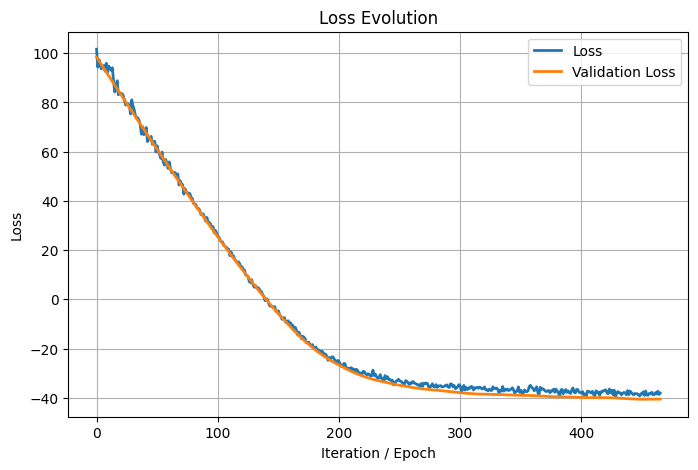

In [11]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

52 52
tensor([-1.0680e+01,  3.9961e+00,  6.3362e+00,  7.8085e+00,  8.0610e+00,
        -1.0738e+01,  3.7505e+00,  6.7017e+00,  8.5195e+00,  8.9831e+00,
         4.1124e-02, -4.4531e-02,  2.0350e-02,  1.0231e-02,  2.0052e-02,
        -1.7450e-02, -1.7109e-03,  1.7430e-03,  2.1976e-02, -3.2896e-02,
         1.7660e-02,  3.2985e-04, -2.8597e-03,  1.7711e-02, -3.7826e-02,
         4.7386e-02,  2.6917e-02,  4.8816e-02,  1.7953e-02,  2.7827e-02,
        -4.0862e-02,  1.0905e-01, -1.5513e-02,  8.3171e-02,  3.2693e-03,
         2.6779e-02, -5.4151e-03,  4.7375e-03,  3.7619e-02,  1.2397e-02,
         1.7278e-02, -2.9656e-02,  7.2721e-02, -5.4442e-02, -1.9973e-02,
        -1.8277e-02,  3.2669e-02, -3.1648e-02,  5.3414e-02, -1.0640e-02,
        -1.4323e-02,  1.3135e-02])


In [13]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [14]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [15]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [16]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [17]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [18]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.4884
KLD Gaussian Train Data:  0.0827
KLD Copula   Train Data:  -0.0009
KLD GTM      Test  Data:  0.5189
KLD Gaussian Test  Data:  0.109
KLD Copula   Test  Data:  0.0014


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [19]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

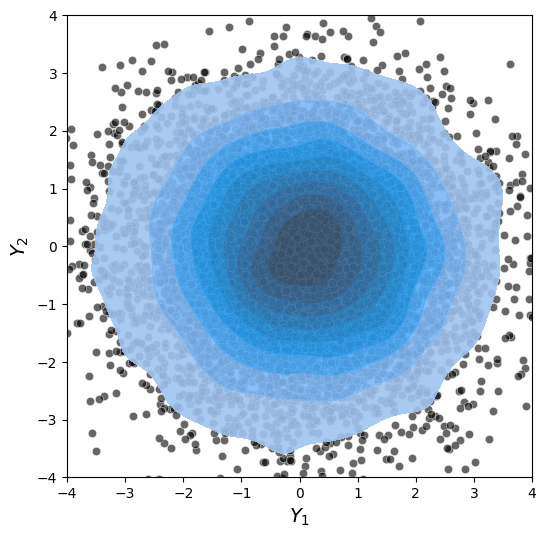

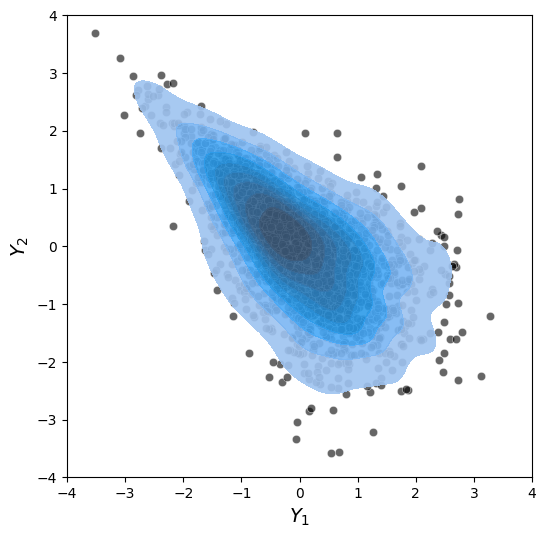

In [20]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [21]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


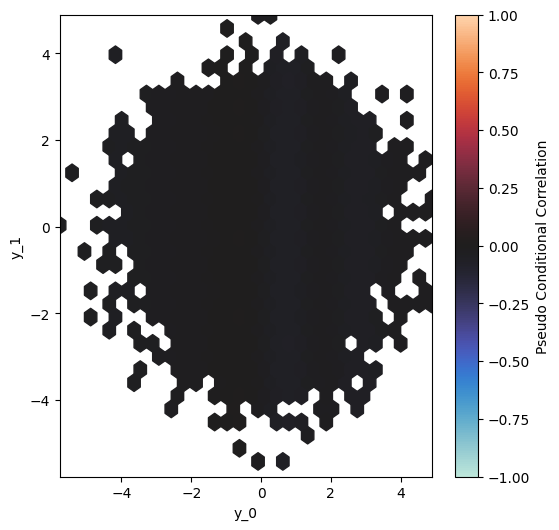

In [22]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


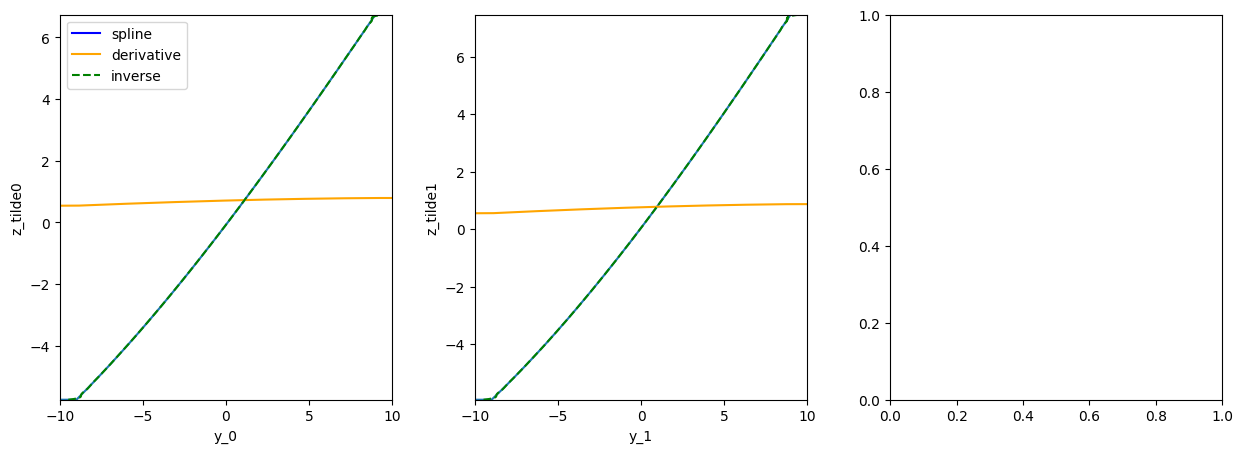

In [23]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


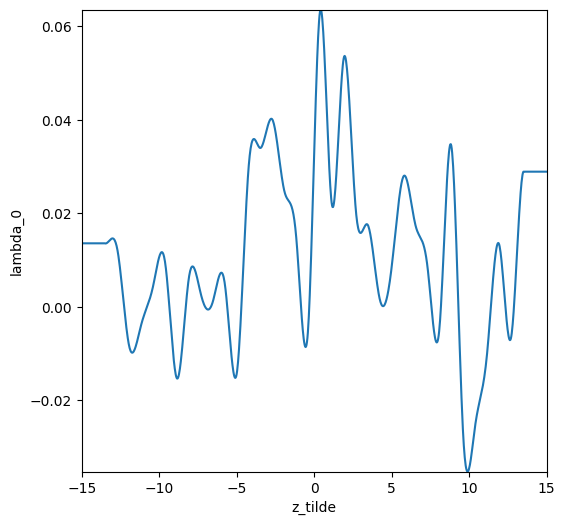

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

ValueError: decorrelation_layer_number exceeds the number of decorrelation layers.

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


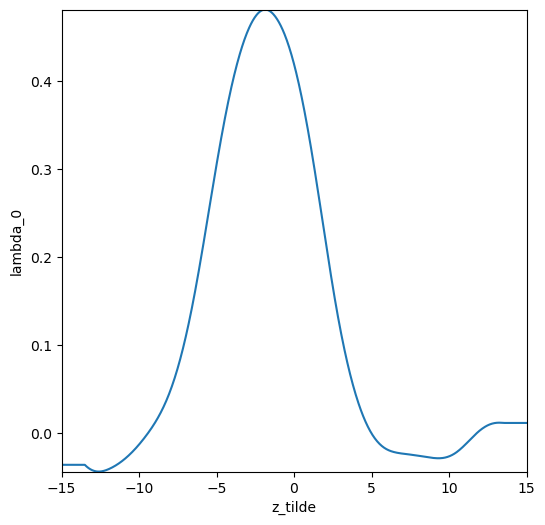

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)